# Import and Functions

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import re
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.interpolate import interp1d
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler
import seaborn as sns
plt.style.use('default')

# Function calculating rest frame wavelength from host redshift
def restFrameWavelength(obs_wavelength, redshift): # takes list of measured wavelengths
    rest_wavelength = []
    for n in range(len(obs_wavelength)):
        rest_wavelength.append(obs_wavelength[n]/(redshift+1))
    return(np.array(rest_wavelength))

# Function that reads in the data from txt. files
def readTxt(file_path, errors):
    # Initialize empty lists to be returned
    values1 = []
    values2 = []
    err_values = []
    
    with open(file_path, 'r') as file:
        for line in file:
            
            # Check the row begins with a number - not holding a column title
            if line[0].isnumeric():
            
                # Split each line into separate values separated by one or more space or commas
                values = re.split(r'[\s,]+', line.strip())
                
                # Convert the values to floats and append them to the respective lists
                if len(values) > 1:
                    values1.append(float(values[0]))
                    values2.append(float(values[1]))
                    if errors == True:
                        err_values.append(abs(float(values[2])))
    
    if errors == True:
        return(np.array(values1), np.array(values2), np.array(err_values))
    else:
        return(np.array(values1), np.array(values2))

# Function that takes an array of mask ranges (2D) in wavelength and masks the wavelength, flux, flux error
def maskWavelength(wav, flux, err, mask):
    for m in mask:
        filter_mask = (wav < m[0]) | (wav > m[1])
        wav = wav[filter_mask]
        flux = flux[filter_mask]
        err = err[filter_mask]
    return(wav, flux, err)

# Function converting flux to luminosity using redshift.
def calcLuminosity(flux, z):
    # Convert flux to luminosity
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3) # Hubble const km/s/Mpc and Density param for matter
    luminosity_distance     = cosmo.luminosity_distance(z).to(u.cm)
    luminosity_distance_cm  = luminosity_distance.value
    
    # Calculate luminosity from fluxes
    L = ((flux*10**-15) * 4 * np.pi * (luminosity_distance_cm)**2)
    return L

# Integrate spectrum between wavelength ranges
def integrate_spectrum_trapezium(wavelength, flux, wl_min, wl_max):
    # Mask the wavelength and flux to select the range between wl_min and wl_max
    mask = (wavelength >= wl_min) & (wavelength <= wl_max)
    wl_selected = wavelength[mask]
    flux_selected = flux[mask]
    # Perform the integration using the trapezium rule
    integral = np.trapz(flux_selected, wl_selected, dx=0.1)
    return integral


# ---------------------------------------- IMPORTING ----------------------------------------
# Define the file paths
file_path_2004 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/6df_spectra/6dFJ0245455-030450-S-VR-j2009.txt'
file_path_2022 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/10JYSElqi_spectra/10JYSElqi_gr4_2022-09-09T05h46h03s_final_red.txt'
file_path_2023 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/10JYSElqi_spectra/10JYSElqi_gr8_2023-09-08T05h29m47s_final_red.txt' # Just H_alpha coverage
file_path_2024 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/10JYSElqi_spectra/28_August_2024_spec/10JYSElqi_WiFeS_20240828.csv'


# Read in the necessary data
wave_04, flux_04 = readTxt(file_path_2004, False)
flux_err_04 = abs(flux_04) * 0.1
wave_22, flux_22, flux_err_22 = readTxt(file_path_2022, True)
wave_23, flux_23, flux_err_23 = readTxt(file_path_2023, True)
wave_24, flux_24 = readTxt(file_path_2024, False)
flux_err_24 = abs(flux_24) * 0.1

# Calibrate spectra by scale factor
#sf_04 = (0.0739809*1e-17 / 0.88) * 0.8601   # scaled to match 2024 [OIII]
#sf_22 = 3.145 * 0.8992        # in between ZTF r- and g- factor of 3.287 and 3.003
#sf_23 = 1 / 0.7247       # scaled to match 2024 [NII]
# scale factors matching integrated [O III]5007 to 2024
sf_04 = 7.230792282954545e-19
sf_22 = 2.827984
sf_23 = 1.3798813302056023 # scaled to [N II] with [O III] not present

# Scale the flux & err
flux_04 = flux_04 * sf_04
flux_err_04 = flux_err_04 * sf_04
flux_22 = flux_22 * sf_22
flux_err_22 = flux_err_22 * sf_22
flux_23 = flux_23 * sf_23
flux_err_23 = flux_err_23 * sf_23
'''
# Remove negative error values - replace with absolute value
for i in range(len(flux_err_22)):
    if flux_error_2022[i] < 0:
        flux_error_2022[i] = abs(flux_error_2022[i])
'''
#'''
# Apply wave_mask here since PyQSOFit doesn't work with wave_mask at the moment.
def remove_noise(flux, err, wave, indices_to_remove):
    flux = np.delete(flux, indices_to_remove)
    err = np.delete(err, indices_to_remove)
    wave = np.delete(wave, indices_to_remove)
    return flux, err, wave

# Remove noise from spectra - similar to PyQSOFit code
flux_04, flux_err_04, wave_04 = remove_noise(flux_04, flux_err_04, wave_04, 
                                             np.where((wave_04 > 5568) & (wave_04 < 5608))[0])
flux_22, flux_err_22, wave_22 = remove_noise(flux_22, flux_err_22, wave_22, 
                                             np.where((wave_22 > 5271) & (wave_22 < 5283))[0])
flux_24, flux_err_24, wave_24 = remove_noise(flux_24, flux_err_24, wave_24,
                                             np.where(wave_24 < 0)[0])
#'''

# Convert to rest frame wavelength
z = 0.074550 # redshift of host galaxy
rest_wave_04 = restFrameWavelength(wave_04, z)
rest_wave_22 = restFrameWavelength(wave_22, z)
rest_wave_23 = restFrameWavelength(wave_23, z)
rest_wave_24 = restFrameWavelength(wave_24, z)

In [3]:
# Scale all spectra to be in units of 10^-15 erg/s/cm2/A
flux_04 = flux_04 * 1e15
flux_22 = flux_22 * 1e15
flux_23 = flux_23 * 1e15
flux_24 = flux_24 * 1e15

In [4]:
# Resample 2024 to smooth it
input_spectra = Spectrum1D(
    flux = flux_24 * (u.erg / u.s / u.cm**2 / u.AA),
    spectral_axis = rest_wave_24 * u.AA)
resample_grid = np.linspace(rest_wave_24.min()+1, rest_wave_24.max()-1, int(len(rest_wave_24)/2))  * u.AA # By a factor of 2
flux_resample = FluxConservingResampler()
sampled_24_spectra = flux_resample(input_spectra, resample_grid)

#plt.figure(figsize=[10,5])
#plt.plot(wave_24, flux_24)
#plt.plot(sampled_24_spectra.spectral_axis, sampled_24_spectra.flux)
#plt.show()

In [5]:
sf_04 = (0.0739809*1e-17 / 0.88) * 0.8601
sf_22 = 3.145 * 0.8992 
sf_23 = 1 / 0.7247 

print(sf_04, sf_22, sf_23)

7.230792282954545e-19 2.827984 1.3798813302056023


# Spectra Plot

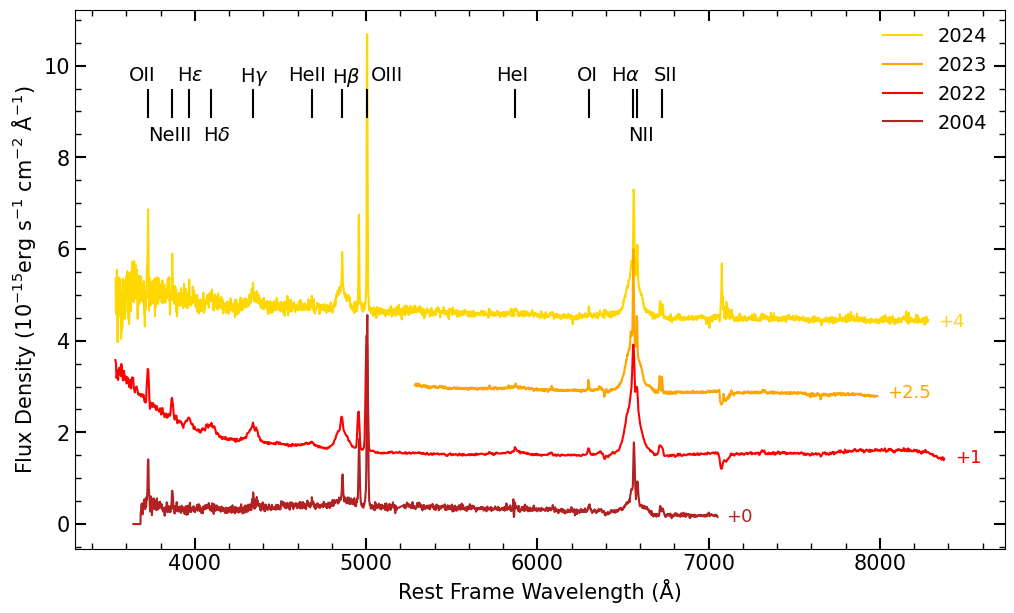

In [6]:
# Plot 2009 against 2022 on same plot
# For Leicester flash talk
plt.figure(figsize=(12,7))

# Wave masks
#wave_mask_2022 = np.array([[4905,4915]])
#wave_mask_2004 = np.array([[3600,3685], [5185, 5205]])

# Apply wave masks
#rest_wavelength_2022, flux_2022, flux_error_2022 = maskWavelength(rest_wavelength_2022, flux_2022, flux_error_2022, wave_mask_2022)
#rest_wavelength_2004, flux_2004, flux_error_2004 = maskWavelength(rest_wavelength_2004, flux_2004, flux_error_2004, wave_mask_2004)

#005c84 Southampton Logo Blue Hex Colour
#plt.plot(rest_wave_24, flux_24+4e-15, color='green', label='2024')
plt.plot(sampled_24_spectra.spectral_axis, sampled_24_spectra.flux+(4* (u.erg / u.s / u.cm**2 / u.AA)), color='gold', label='2024')
#plt.errorbar(rest_wave_24, flux_24, yerr = flux_err_24, color='skyblue', alpha=0.1)
plt.plot(rest_wave_23, flux_23+2.5, color='orange', label='2023')
#plt.errorbar(rest_wave_23, flux_23, yerr = flux_err_23, color='skyblue', alpha=0.1)
plt.plot(rest_wave_22, flux_22+1, color='red', label='2022')
#plt.errorbar(rest_wave_22, flux_22, yerr = flux_err_22, color='skyblue', alpha=0.1)
plt.plot(rest_wave_04, flux_04, color='firebrick', label='2004')
#plt.errorbar(rest_wave_04, flux_04, yerr = flux_err_04, color='dimgrey', alpha=0.1)

# Label vertical offset
plt.text(7100, 0.05, '+0', fontsize=13, color='firebrick') # x-loc = 7080
plt.text(8440, 1.35, '+1', fontsize=13, color='red') # x-loc = 8400
plt.text(8040, 2.75, '+2.5', fontsize=13, color='orange') # x-loc = 8020
plt.text(8340, 4.3, '+4', fontsize=13, color='gold') # x-loc = 8320

plt.xlim(3300, 8730)
#plt.ylim(-10, 190)
#plt.ylim(-0.075e-14, 0.875e-14)

plt.ylabel(r'Flux Density ($10^{-15}$erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=15)
plt.xlabel('Rest Frame Wavelength (Å)', fontsize=15)

# Set the axis ticks
xticks = range(4000, 8001, 1000)
plt.xticks(xticks)
#yticks = range(0, 200, 50)
#plt.yticks(yticks)
plt.tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=15, length=8, width=1.5)
plt.tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=15, length=4, width=1)
plt.minorticks_on()
plt.legend(frameon=False, fontsize=14)

# Emission lines data
emission_lines = np.array([6560.560227, 6581.214549, 6728.512481, 6299.266023, 5845.640105+22, 4857.758798, 5007, 4682.276502, 4340.800103, 4092.282026, 3965.833107, 3866.774891, 3725.946058]) # array of emission line peak wavelengths (2022 PyQSOFit)
labels =        [r'H$\alpha$', 'NII', 'SII', 'OI', 'HeI', r'H$\beta$', 'OIII', 'HeII', r'H$\gamma$', r'H$\delta$', r'H$\epsilon$', 'NeIII', 'OII']
line_height =   [0.8,           0.8,   0.8,   0.8,  0.8,   0.8,         0.8,    0.8,    0.8,            0.8,        0.8,            0.8,     0.8]
label_height =  [10,            8.7,   10,    10,   10,    10,          10,     10,     10,             8.7,       10,              8.7,     10]
label_x_adjust= [-130,          -50,   -50,   -70,  -110,  -55,         20,    -140,    -75,            -45,        -70,            -140,    -110]

# Add vertical dashed lines and labels
for line, label, height, adjust_y, adjust_x in zip(emission_lines, labels, line_height, label_height, label_x_adjust):
    plt.axvline(x=line, color='black', linestyle='-', ymin=height, ymax=height+0.05)  # Draw a vertical dashed line # was ymin = 0.8 to 0.85
    plt.text(line+adjust_x, adjust_y, label, verticalalignment='top', fontsize=14, color='black')  # Add label

# Save figure
custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
custom_filename = "spectra_evolution.png"
save_path = custom_path + custom_filename
#plt.savefig(save_path)
plt.show()

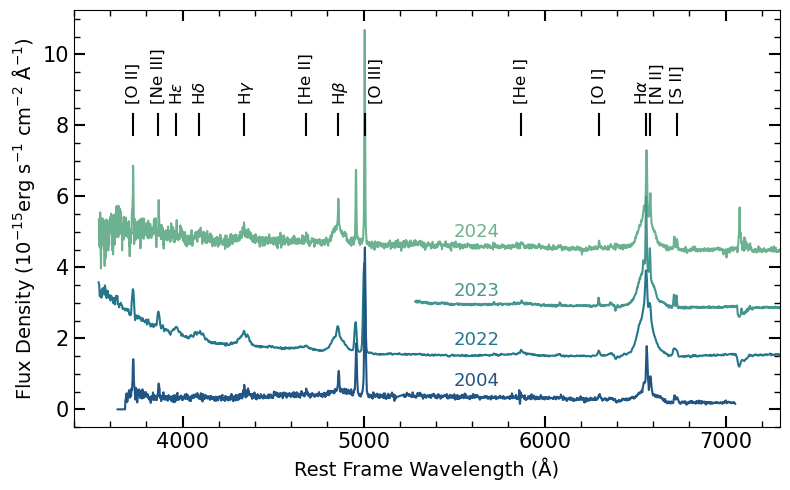

In [9]:
plt.figure(figsize=(8,5))

# Generate a seaborn palette with as many colors as you need
colors = sns.color_palette("crest", n_colors=4) # crest

#005c84 Southampton Logo Blue Hex Colour
#plt.plot(rest_wave_24, flux_24+4e-15, color='green', label='2024')
plt.plot(sampled_24_spectra.spectral_axis, sampled_24_spectra.flux+(4* (u.erg / u.s / u.cm**2 / u.AA)), color=colors[0], label='2024')
#plt.errorbar(rest_wave_24, flux_24, yerr = flux_err_24, color='skyblue', alpha=0.1)
plt.plot(rest_wave_23, flux_23+2.5, color=colors[1], label='2023')
#plt.errorbar(rest_wave_23, flux_23, yerr = flux_err_23, color='skyblue', alpha=0.1)
plt.plot(rest_wave_22, flux_22+1, color=colors[2], label='2022')
#plt.errorbar(rest_wave_22, flux_22, yerr = flux_err_22, color='skyblue', alpha=0.1)
plt.plot(rest_wave_04, flux_04, color=colors[3], label='2004')
#plt.errorbar(rest_wave_04, flux_04, yerr = flux_err_04, color='dimgrey', alpha=0.1)

# Label spectra
plt.text(5500, 0.65, '2004', fontsize=13, color=colors[3]) # x-loc = 7080
plt.text(5500, 1.8, '2022', fontsize=13, color=colors[2]) # x-loc = 8400
plt.text(5500, 3.2, '2023', fontsize=13, color=colors[1]) # x-loc = 8020
plt.text(5500, 4.85,  '2024', fontsize=13, color=colors[0]) # x-loc = 8320

plt.xlim(3400, 7300)
plt.ylim(-0.5, 11.25)
#plt.ylim(-0.075e-14, 0.875e-14)

plt.ylabel(r'Flux Density ($10^{-15}$erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=14)
plt.xlabel('Rest Frame Wavelength (Å)', fontsize=14)

# Set the axis ticks
xticks = range(4000, 7001, 1000)
plt.xticks(xticks)
#yticks = range(0, 200, 50)
#plt.yticks(yticks)
plt.tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=15, length=8, width=1.5)
plt.tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=15, length=4, width=1)
plt.minorticks_on()
#plt.legend(frameon=False, fontsize=14)

# Emission lines data
emission_lines = np.array([6560.560227, 6581.214549, 6728.512481, 6299.266023, 5845.640105+22, 4857.758798, 5007, 4682.276502, 4340.800103, 4092.282026, 3965.833107, 3866.774891, 3725.946058]) # array of emission line peak wavelengths (2022 PyQSOFit)
labels =        [r'H$\alpha$','[N II]','[S II]','[O I]','[He I]',r'H$\beta$','[O III]','[He II]',r'H$\gamma$',r'H$\delta$',r'H$\epsilon$','[Ne III]','[O II]']
line_height =   [0.8,           0.8,     0.8,     0.8,    0.8,     0.8,        0.8,      0.8,      0.8,         0.8,         0.8,           0.8,       0.8]
label_height =  [9.76,          9.8,     9.8,     9.8,    9.8,     9.76,       9.8,      9.8,      9.76,        9.76,        9.76,          9.8,       9.8]
label_x_adjust= [-65,           0,       -35,     -40,    -40,     -40,        20,       -40,      -40,         -40,         -40,           -40,       -40]

# Add vertical dashed lines and labels
for line, label, height, adjust_y, adjust_x in zip(emission_lines, labels, line_height, label_height, label_x_adjust):
    plt.axvline(x=line, color='black', linestyle='-', ymin=height-0.1, ymax=height-0.05)  # Draw a vertical dashed line # was ymin = 0.8 to 0.85
    plt.text(line+adjust_x, adjust_y-1.2, label, verticalalignment='bottom', fontsize=12, color='black', rotation='vertical')  # Add label

plt.tight_layout()

# Save figure
custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
custom_filename = "spectra_evolution_for_paper.png"
save_path = custom_path + custom_filename
#plt.savefig(save_path, bbox_inches='tight', dpi=400)
plt.show()

# Spectra Plot (No Offset)

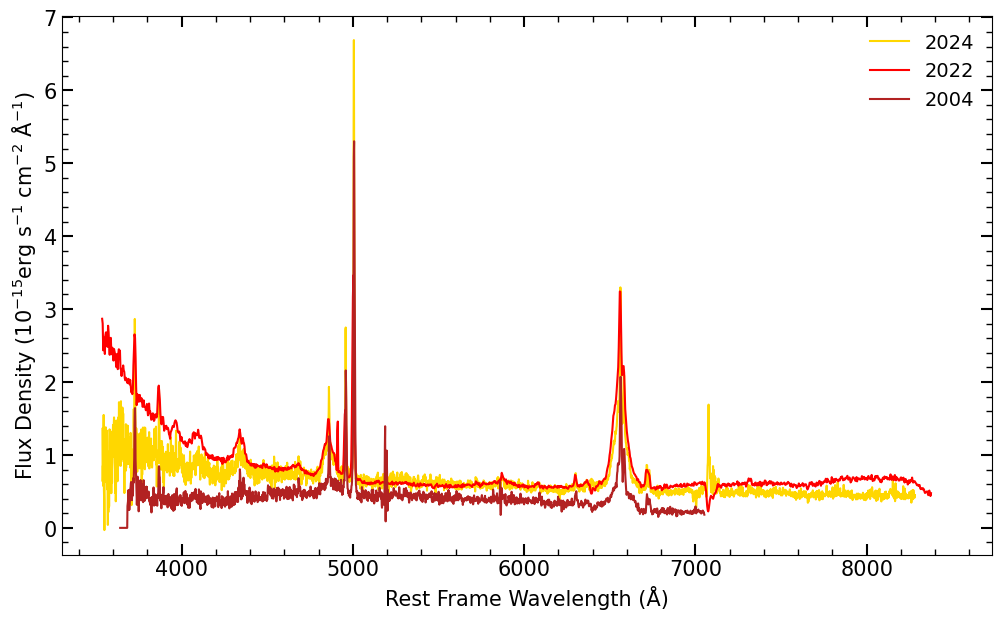

In [14]:
# Plot 2009 against 2022 on same plot
# For Leicester flash talk
plt.figure(figsize=(12,7))

# Wave masks
#wave_mask_2022 = np.array([[4905,4915]])
#wave_mask_2004 = np.array([[3600,3685], [5185, 5205]])

# Apply wave masks
#rest_wavelength_2022, flux_2022, flux_error_2022 = maskWavelength(rest_wavelength_2022, flux_2022, flux_error_2022, wave_mask_2022)
#rest_wavelength_2004, flux_2004, flux_error_2004 = maskWavelength(rest_wavelength_2004, flux_2004, flux_error_2004, wave_mask_2004)

#005c84 Southampton Logo Blue Hex Colour
#plt.plot(rest_wave_24, flux_24+4e-15, color='green', label='2024')
plt.plot(sampled_24_spectra.spectral_axis, sampled_24_spectra.flux, color='gold', label='2024')
#plt.errorbar(rest_wave_24, flux_24, yerr = flux_err_24, color='skyblue', alpha=0.1)
plt.plot(rest_wave_22, flux_22, color='red', label='2022')
#plt.errorbar(rest_wave_22, flux_22, yerr = flux_err_22, color='skyblue', alpha=0.1)
plt.plot(rest_wave_04, flux_04, color='firebrick', label='2004')
#plt.errorbar(rest_wave_04, flux_04, yerr = flux_err_04, color='dimgrey', alpha=0.1)

plt.xlim(3300, 8730)
#plt.ylim(-10, 190)
#plt.ylim(-0.075e-14, 0.875e-14)

plt.ylabel(r'Flux Density ($10^{-15}$erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=15)
plt.xlabel('Rest Frame Wavelength (Å)', fontsize=15)

# Set the axis ticks
xticks = range(4000, 8001, 1000)
plt.xticks(xticks)
#yticks = range(0, 200, 50)
#plt.yticks(yticks)
plt.tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=15, length=8, width=1.5)
plt.tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=15, length=4, width=1)
plt.minorticks_on()
plt.legend(frameon=False, fontsize=14)

In [27]:
# Calculate the L1 L2 fluxes for Feng+14 BH Mass estimate.
L1_04 = calcLuminosity(integrate_spectrum_trapezium(rest_wave_04, flux_04, 4761.8, 4844.6), 0.074550) # The spectra are scaled by 1e15 corrected in calcLuminosity
L2_04 = calcLuminosity(integrate_spectrum_trapezium(rest_wave_04, flux_04, 4727.3, 4751.2), 0.074550)

L1_22 = calcLuminosity(integrate_spectrum_trapezium(rest_wave_22, flux_22, 4761.8, 4844.6), 0.074550)
L2_22 = calcLuminosity(integrate_spectrum_trapezium(rest_wave_22, flux_22, 4727.3, 4751.2), 0.074550)

L1_24 = calcLuminosity(integrate_spectrum_trapezium(rest_wave_24, flux_24, 4761.8, 4844.6), 0.074550)
L2_24 = calcLuminosity(integrate_spectrum_trapezium(rest_wave_24, flux_24, 4727.3, 4751.2), 0.074550)

print(L1_04, L2_04, L1_22, L2_22, L1_24, L2_24)

5.838558889677987e+26 1.3438166964657508e+26 9.401228488717022e+26 1.9257206549987714e+26 9.00999727720613e+26 2.2285959050341013e+26


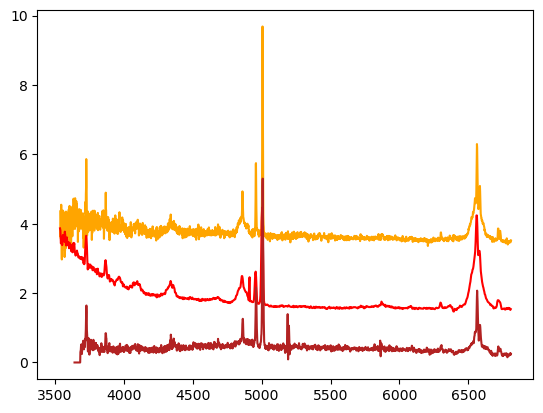

In [62]:
def cut_array(arr, threshold):
    return arr[arr <= threshold]

# Convert 2024 data into array format
rest_wave_24 = np.array(sampled_24_spectra.spectral_axis.value)
flux_24 = np.array(sampled_24_spectra.flux.value)

rest_wave_24 = cut_array(rest_wave_24, 6810)
flux_24 = flux_24[:len(rest_wave_24)]
rest_wave_22 = cut_array(rest_wave_22, 6810)
flux_22 = flux_22[:len(rest_wave_22)]
rest_wave_04 = cut_array(rest_wave_04, 6810)
flux_04 = flux_04[:len(rest_wave_04)]

plt.plot(rest_wave_24, flux_24+3, color='orange', label='2024')
plt.plot(rest_wave_22, flux_22+1, color='red', label='2022')
plt.plot(rest_wave_04, flux_04, color='firebrick', label='2004')
plt.show()

# Adjusted Scaling and more Spectra!

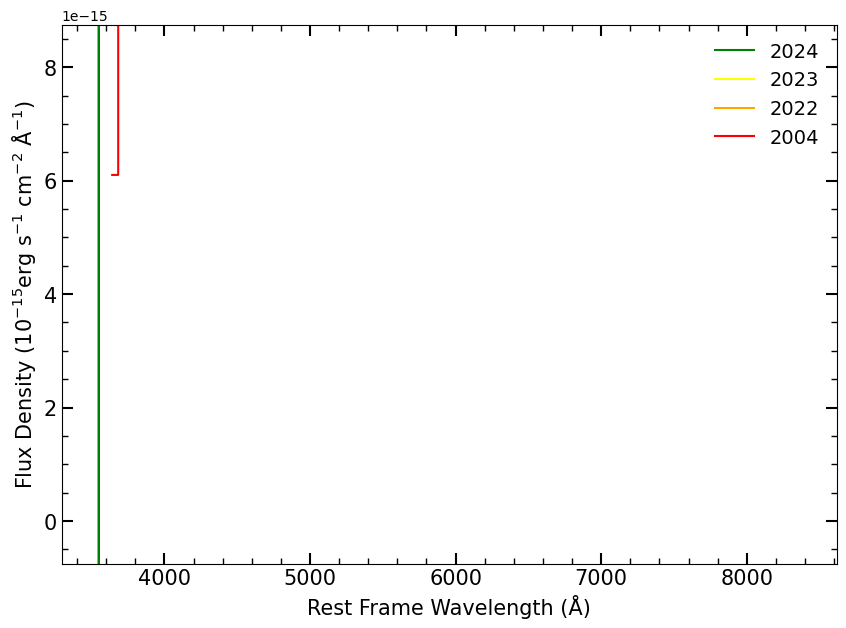

In [5]:
# Plot 2009 against 2022 on same plot
# For Leicester flash talk
plt.figure(figsize=(10,7))

'''
# Emission lines data
emission_lines = np.array([6560.560227, 6581.214549, 6728.512481, 6299.266023, 5845.640105+22, 4857.758798, 5007, 4682.276502, 4340.800103, 4092.282026, 3965.833107, 3866.774891, 3725.946058]) # array of emission line peak wavelengths (2022 PyQSOFit)
labels = [r'H$\alpha$', 'N II', 'S II', 'O I', 'HeI', r'H$\beta$', 'O III', 'He II', r'H$\gamma$', r'H$\delta$', r'H$\epsilon$', 'Ne III', 'O II']  # Greek letters
#label_height = [125, 95, 55, 50, 50, 70, 80, 50, 70, 70, 75, 90, 110]
line_height = [0.72, 0.55, 0.32, 0.32, 0.32, 0.44, 0.85, 0.345, 0.42, 0.42, 0.45, 0.52, 0.62]
label_adjust = [-55, 0, -50, -50, -75, -55, -65, -75, -55, -55, -55, -80, -60]

# Add vertical dashed lines and labels
for line, label, height, adjust in zip(emission_lines, labels, line_height, label_adjust):
    plt.axvline(x=line, color='black', linestyle='-', ymin=height, ymax=height+0.05)  # Draw a vertical dashed line # was ymin = 0.8 to 0.85
    plt.text(line+adjust, 200*height+11, label, verticalalignment='top', fontsize=12, color='black')  # Add label

# Label 2022 vertical offset
plt.text(7000, 45, '+20', fontsize=12, color='blue')  # Add label
'''

#005c84 Southampton Logo Blue Hex Colour
#plt.plot(rest_wave_24, flux_24, color='green', label='2024')
plt.plot(sampled_24_spectra.spectral_axis, sampled_24_spectra.flux, color='green', label='2024')
#plt.errorbar(rest_wave_24, flux_24, yerr = flux_err_24, color='skyblue', alpha=0.1)
plt.plot(rest_wave_23, flux_23+ 1.7e-15, color='yellow', label='2023')
#plt.errorbar(rest_wave_23, flux_23, yerr = flux_err_23, color='skyblue', alpha=0.1)
plt.plot(rest_wave_22, flux_22+ 3.7e-15, color='orange', label='2022')
#plt.errorbar(rest_wave_22, flux_22, yerr = flux_err_22, color='skyblue', alpha=0.1)
plt.plot(rest_wave_04, flux_04+ 6.1e-15, color='red', label='2004')
#plt.errorbar(rest_wave_04, flux_04, yerr = flux_err_04, color='dimgrey', alpha=0.1)

#plt.xlim(3500, 7300)
#plt.ylim(-10, 190)
plt.ylim(-0.075e-14, 0.875e-14)

plt.ylabel(r'Flux Density ($10^{-15}$erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=15)
plt.xlabel('Rest Frame Wavelength (Å)', fontsize=15)

# Set the axis ticks
xticks = range(4000, 8001, 1000)
plt.xticks(xticks)
#yticks = range(0, 200, 50)
#plt.yticks(yticks)
plt.tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=15, length=8, width=1.5)
plt.tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=15, length=4, width=1)
plt.minorticks_on()
plt.legend(frameon=False, fontsize=14)


# Save figure
custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
custom_filename = "spectra.png"
save_path = custom_path + custom_filename
#plt.savefig(save_path)
plt.show()

# Calculating Spectral Change

In [6]:
# Find wavelength limits of 2009 spectra and create mask to crop 2022
lower_limit_2004 = rest_wavelength_2004.min()
upper_limit_2004 = rest_wavelength_2004.max()
mask = (rest_wavelength_2022 > lower_limit_2004) & (rest_wavelength_2022 < upper_limit_2004)

# Crop the 2022 spectra
rest_wavelength_2022_cropped = rest_wavelength_2022[mask]
flux_2022_cropped = flux_2022[mask]
flux_error_2022_cropped = flux_error_2022[mask]

# Interpolate the second spectrum to match the x-axis of the first spectrum
interp_function = interp1d(rest_wavelength_2022_cropped, flux_2022_cropped, kind='linear', bounds_error=False, fill_value="extrapolate")
flux_2022_interp = interp_function(rest_wavelength_2004)

# Experimental interpolation to use for errors
interp_error_function = interp1d(rest_wavelength_2022_cropped, flux_error_2022_cropped, kind='linear', bounds_error=False, fill_value="extrapolate")
flux_error_2022_interp = interp_error_function(rest_wavelength_2004)

# Subtract the spectra
flux_difference = flux_2022_interp - flux_2004
flux_difference_error = np.sqrt(flux_error_2022_interp**2 + flux_error_2004**2)

# Mask narrow HB, both OIII, HeI, HA, NII - peak wavelengths taken from PyQSOFit
narrow_line_peaks = [4855, 4952, 5002, 5862, 6563, 6576]
mask_lines = np.ones(len(rest_wavelength_2004), dtype=bool)
for line in narrow_line_peaks:
    mask_lines &= (np.abs(rest_wavelength_2004 - line) > 15)

flux_difference_masked = flux_difference[mask_lines]
flux_difference_error_masked = flux_difference_error[mask_lines]
rest_wavelength_masked = rest_wavelength_2004[mask_lines]


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(rest_wavelength_2004, flux_2004, 'r-', label='2004')
plt.plot(rest_wavelength_2022, flux_2022, 'g-', label='2022')
plt.plot(rest_wavelength_masked, flux_difference_masked, color='black', alpha = 0.5, label='2022-2004')
#plt.errorbar(rest_wavelength_2009, flux_2009, yerr = flux_error_2009, color='red', alpha=0.2)
#plt.errorbar(rest_wavelength_2022, flux_2022, yerr = flux_error_2022, color='green', alpha=0.2)
#plt.errorbar(rest_wavelength_masked, flux_difference_masked, yerr = flux_difference_error_masked, color='black', alpha=0.2)
plt.legend(frameon=False, fontsize=14)
plt.ylabel(r'Flux Density ($10^{-17}$erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=15)
plt.xlabel('Rest Frame Wavelength (Å)', fontsize=15)
plt.title('Spectrum: 2004, 2022, Change')
xticks = range(4000, 7001, 1000)
plt.xticks(xticks)
yticks = range(0, 160, 50)
plt.yticks(yticks)
plt.tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=15, length=8, width=1.5)
plt.tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=15, length=4, width=1)
plt.minorticks_on()
plt.xlim(3600, 7200)
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(rest_wavelength_masked, flux_difference_masked, yerr = flux_difference_error_masked, color='black', alpha=0.2)
plt.plot(rest_wavelength_masked, flux_difference_masked, color='blue', label='2022-2004')
plt.legend(frameon=False, fontsize=14)
plt.ylabel(r'Flux Density ($10^{-17}$erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=15)
plt.xlabel('Rest Frame Wavelength (Å)', fontsize=15)
plt.title('Spectral Change Between 2004 and 2022')
xticks = range(4000, 7001, 1000)
plt.xticks(xticks)
yticks = range(0, 80, 20)
plt.yticks(yticks)
plt.tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=15, length=8, width=1.5)
plt.tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=15, length=4, width=1)
plt.minorticks_on()
plt.xlim(3600, 7200)

# Save figure
custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
custom_filename = "SpectralChange.png"
save_path = custom_path + custom_filename
#plt.savefig(save_path)
plt.show()

NameError: name 'rest_wavelength_2004' is not defined

In [ ]:
# Testing pyqsofit line masks!
line_mask = np.where(
                    (rest_wavelength_2022 < 4970) & (rest_wavelength_2022 > 4950) | (rest_wavelength_2022 < 5020) & (rest_wavelength_2022 > 5000) |
                    (rest_wavelength_2022 < 6590) & (rest_wavelength_2022 > 6540) | (rest_wavelength_2022 < 6740) & (rest_wavelength_2022 > 6710) |
                    (rest_wavelength_2022 < 3737) & (rest_wavelength_2022 > 3717) | (rest_wavelength_2022 < 4872) & (rest_wavelength_2022 > 4852) |
                    (rest_wavelength_2022 < 4350) & (rest_wavelength_2022 > 4330) | (rest_wavelength_2022 < 4111) & (rest_wavelength_2022 > 4091),
                    True, False)
line_mask_range = [[4950, 4970], [5000, 5020], [6540, 6590], [6710, 6740], [3717, 3737], [4852, 4872], [4330, 4350], [4091, 4111]]

In [ ]:
# Plot 2004 against 2022 on same plot
# For Leicester flash talk
plt.figure(figsize=(10,5))

# Wave masks
wave_mask_2022 = np.array([[4905,4915]])
wave_mask_2004 = np.array([[3600,3685], [5185, 5205]])

# Apply wave masks
rest_wavelength_2022, flux_2022, flux_error_2022 = maskWavelength(rest_wavelength_2022, flux_2022, flux_error_2022, wave_mask_2022)
rest_wavelength_2004, flux_2004, flux_error_2004 = maskWavelength(rest_wavelength_2004, flux_2004, flux_error_2004, wave_mask_2004)

# Emission lines data
emission_lines = np.array([6560.560227, 6581.214549, 6728.512481, 6299.266023, 5845.640105+22, 4857.758798, 5007, 4682.276502, 4340.800103, 4092.282026, 3965.833107, 3866.774891, 3725.946058]) # array of emission line peak wavelengths (2022 PyQSOFit)
labels = [r'H$\alpha$', 'N II', 'S II', 'O I', 'HeI', r'H$\beta$', 'O III', 'He II', r'H$\gamma$', r'H$\delta$', r'H$\epsilon$', 'Ne III', 'O II']  # Greek letters
#label_height = [125, 95, 55, 50, 50, 70, 80, 50, 70, 70, 75, 90, 110]
line_height = [0.72, 0.55, 0.32, 0.32, 0.32, 0.44, 0.85, 0.345, 0.42, 0.42, 0.45, 0.52, 0.62]
label_adjust = [-55, 0, -50, -50, -75, -55, -65, -75, -55, -55, -55, -80, -60]

# Add vertical dashed lines and labels
for line, label, height, adjust in zip(emission_lines, labels, line_height, label_adjust):
    plt.axvline(x=line, color='black', linestyle='-', ymin=height, ymax=height+0.05)  # Draw a vertical dashed line # was ymin = 0.8 to 0.85
    plt.text(line+adjust, 200*height+11, label, verticalalignment='top', fontsize=12, color='black')  # Add label


#005c84 Southampton Logo Blue Hex Colour
#plt.plot(rest_wavelength_2009, flux_2009, color='dimgrey', label='2009')
plt.plot(rest_wavelength_2022, flux_2022+20, color='blue', label='2022')
plt.plot(rest_wavelength_2004, flux_2004, color='dimgrey', label='2004')
plt.errorbar(rest_wavelength_2022, flux_2022+20, yerr = flux_error_2022, color='skyblue', alpha=0.07)
plt.errorbar(rest_wavelength_2004, flux_2004, color='dimgrey', alpha=0.2)

plt.xlim(3500, 7300)
plt.ylim(-10, 190)

plt.ylabel(r'Flux Density ($10^{-17}$erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=15)
plt.xlabel('Rest Frame Wavelength (Å)', fontsize=15)

# Set the axis ticks
xticks = range(4000, 7001, 1000)
plt.xticks(xticks)
yticks = range(0, 200, 50)
plt.yticks(yticks)
plt.tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=15, length=8, width=1.5)
plt.tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=15, length=4, width=1)
plt.minorticks_on()
plt.legend(frameon=False, fontsize=14, loc='upper right')

line_mask_range = [[3717, 3737], [3855, 3880], [3930, 3990], [4045, 4130], [4260, 4385], [4570, 4970], [5000, 5020], [5845, 5895], [6290, 6310], [6400, 6740]]

line_mask = np.where(
                    (rest_wavelength_2022 < 3737) & (rest_wavelength_2022 > 3717) | (rest_wavelength_2022 < 3880) & (rest_wavelength_2022 > 3855) |
                    (rest_wavelength_2022 < 3990) & (rest_wavelength_2022 > 3930) | (rest_wavelength_2022 < 4130) & (rest_wavelength_2022 > 4045) |
                    (rest_wavelength_2022 < 4385) & (rest_wavelength_2022 > 4260) | (rest_wavelength_2022 < 4970) & (rest_wavelength_2022 > 4570) |
                    (rest_wavelength_2022 < 5020) & (rest_wavelength_2022 > 5000) | (rest_wavelength_2022 < 5895) & (rest_wavelength_2022 > 5845) |
                    (rest_wavelength_2022 < 6310) & (rest_wavelength_2022 > 6290) | (rest_wavelength_2022 < 6740) & (rest_wavelength_2022 > 6400),
                    True, False)

# Shade line_mask from pyqsofit
for i in range(len(line_mask_range)):
    plt.axvspan(line_mask_range[i][0], line_mask_range[i][1], alpha=0.5, color='red')

plt.show()

In [ ]:
# Plot spectra overlapping to locate emission lines
plt.figure(figsize=(10, 6))
plt.plot(rest_wavelength_2004, flux_2004, 'r-', label='2004')
plt.plot(rest_wavelength_2022, flux_2022, 'g-', label='2022')
plt.legend(frameon=False, fontsize=14)
plt.ylabel(r'Flux Density ($10^{-17}$erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=15)
plt.xlabel('Rest Frame Wavelength (Å)', fontsize=15)
plt.title('Spectrum: 2004, 2022, Change')
xticks = range(4000, 7001, 1000)
plt.xticks(xticks)
yticks = range(0, 81, 10)
plt.yticks(yticks)
plt.tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=15, length=8, width=1.5)
plt.tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=15, length=4, width=1)
plt.minorticks_on()
plt.xlim(3600, 7200)
plt.ylim(0, 80)
plt.show()

In [5]:
(23.5/25)*0.3 + (9/10)*0.1 + (1/10)*0.1 + (24/25)*0.5

0.862

In [6]:
0.683+6.688

7.3709999999999996